# Initial Environment Setup

In [1]:
!pip install torch
!pip install torch_geometric
!pip install pandas
!pip install matplotlib
!pip install pydot
!pip install graphviz

import os
import torch
import torch.nn.functional as F

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=08f58a8d1c4851e20d06e1307b3dd7248709aa3cc6adf3b34757a99fdef80033
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 42.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Data Analysis

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [3]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [4]:
import pandas as pd

# Example list

# Count occurrences and create a dictionary
count_dict = {}
for value in data.y.tolist():
    count_dict[value] = count_dict.get(value, 0) + 1

# Create dataframe from the dictionary
df = pd.DataFrame(count_dict.items(), columns=['Entity', 'Count'])

# Print the dataframe
print(df)

   Entity  Count
0       3    818
1       4    426
2       0    351
3       2    418
4       1    217
5       5    298
6       6    180


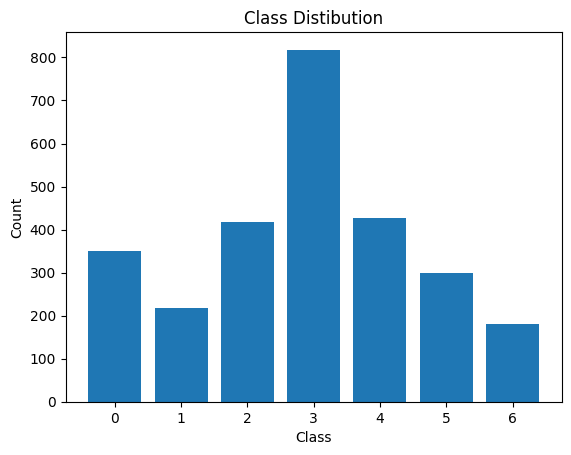

In [5]:
import matplotlib.pyplot as plt

# Plot the distribution
plt.bar(df['Entity'], df['Count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distibution')
plt.show()

In [6]:
data.y[data.train_mask]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2, 0, 0, 4, 3, 3, 3, 2, 3, 1, 3, 5, 3, 4, 6,
        3, 3, 6, 3, 2, 4, 3, 6, 0, 4, 2, 0, 1, 5, 4, 4, 3, 6, 6, 4, 3, 3, 2, 5,
        3, 4, 5, 3, 0, 2, 1, 4, 6, 3, 2, 2, 0, 0, 0, 4, 2, 0, 4, 5, 2, 6, 5, 2,
        2, 2, 0, 4, 5, 6, 4, 0, 0, 0, 4, 2, 4, 1, 4, 6, 0, 4, 2, 4, 6, 6, 0, 0,
        6, 5, 0, 6, 0, 2, 1, 1, 1, 2, 6, 5, 6, 1, 2, 2, 1, 5, 5, 5, 6, 5, 6, 5,
        5, 1, 6, 6, 1, 5, 1, 6, 5, 5, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1])

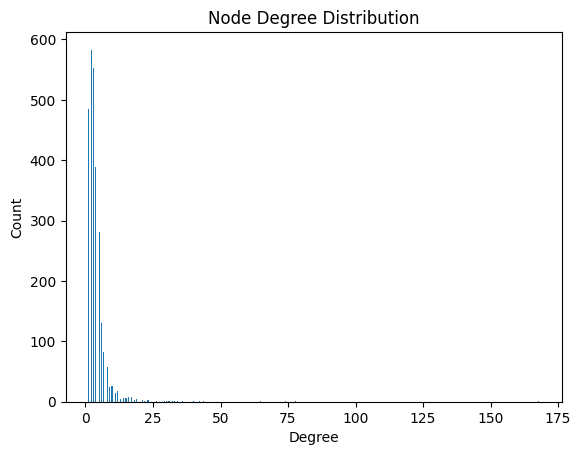

In [7]:
import torch_geometric.utils
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch

degrees = torch_geometric.utils.degree(data.edge_index[0], data.num_nodes)

# Plot degree distribution
plt.hist(degrees, bins="auto")
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Node Degree Distribution')
plt.show()

In [8]:
max(degrees)

tensor(168.)

# GNN Training and Evaluation

In [9]:
# GNN Training an evaluation is heavily based on https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [10]:
# Node Classificaytion Model creation with 2 convolutional layers
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [13]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

<IPython.core.display.Javascript object>

Test Accuracy before Training: 0.0950


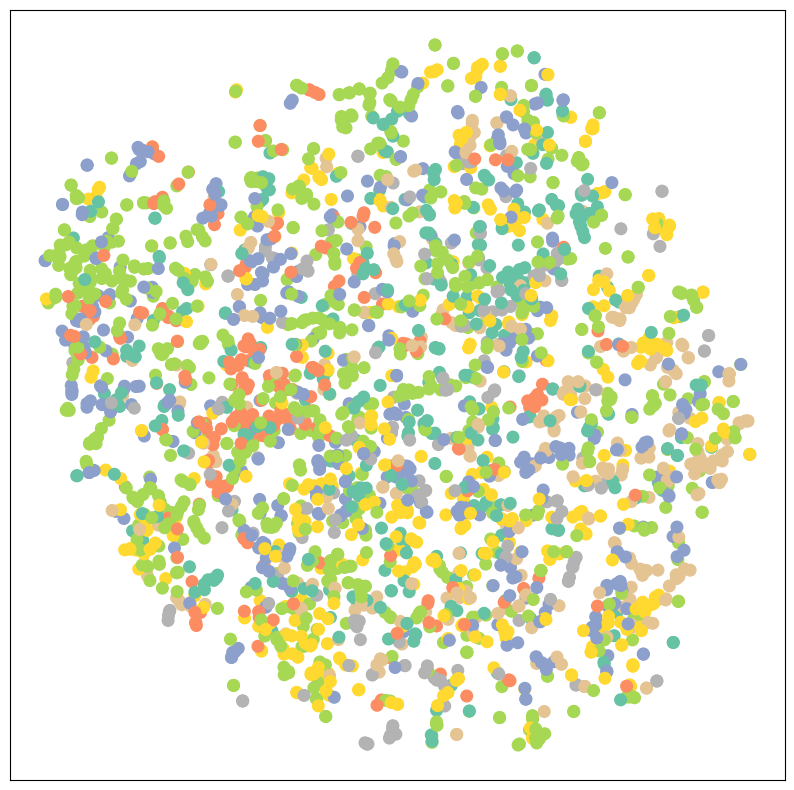

In [14]:
model.eval()

test_acc = test()
print(f'Test Accuracy before Training: {test_acc:.4f}')

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [15]:
# training
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


Test Accuracy after training: 0.8150


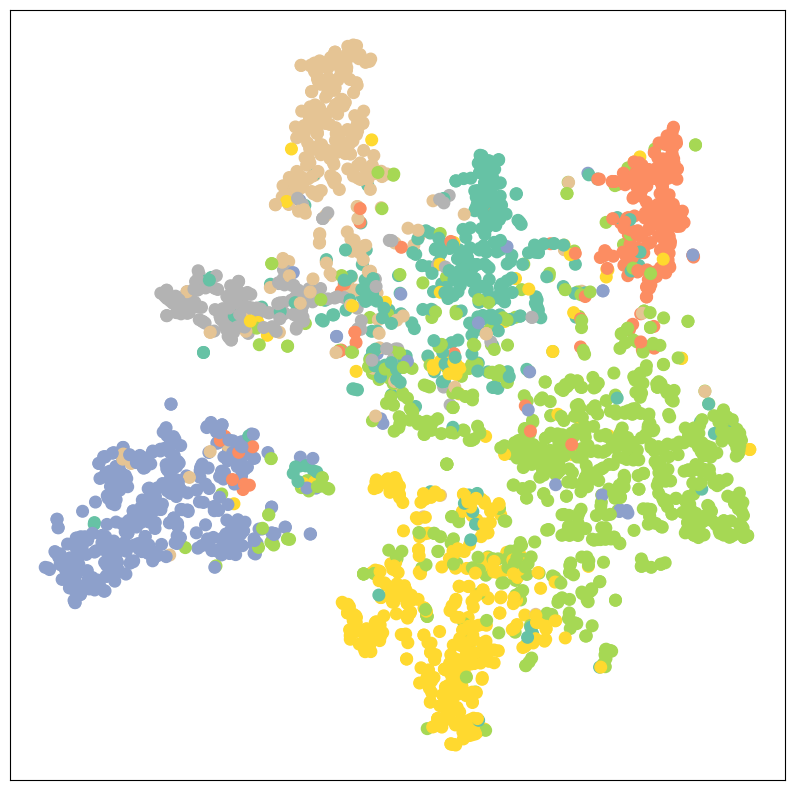

In [16]:
model.eval()

test_acc = test()
print(f'Test Accuracy after training: {test_acc:.4f}')

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# GNN Explanation

Based on the following sources:

https://github.com/pydot/pydot

https://graphviz.org/documentation/

https://pytorch-geometric.readthedocs.io/en/latest/modules/explain.html#torch_geometric.explain.Explanation


In [17]:
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import graphviz
import pydot
from IPython.display import display, Image, display_png


In [18]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    # threshold_config = dict(
    #     threshold_type ="hard",
    #     value = 0.0
    # )
)

## Default explanation

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[ 0.2403,  0.0196, -0.3496,  ...,  0.5438, -0.3199, -0.7708],
        [ 0.4004,  0.0821, -0.5381,  ...,  3.1453, -1.0978, -0.1976],
        [ 0.4525,  0.0232, -0.4915,  ...,  2.4685, -1.0065, -0.4806],
        ...,
        [ 1.3991,  1.0721, -1.9290,  ..., -0.9146,  0.8002, -0.2734],
        [ 0.4402,  0.1981, -0.3511,  ...,  0.8219, -0.3904, -0.9392],
        [ 0.2887,  0.2146, -0.1874,  ...,  0.5880, -0.3355, -0.8654]])
prediction classes: tensor([3, 4, 4,  ..., 0, 3, 3])
ground truth: tensor([3, 4, 4,  ..., 3, 3, 3])


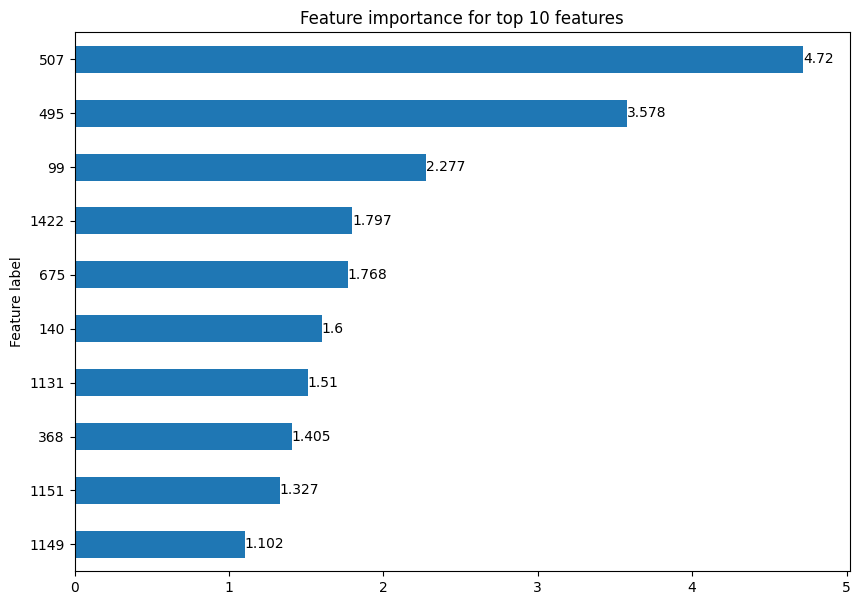

In [19]:
explanation = explainer(data.x, data.edge_index, index=5)
print(explanation.edge_mask)
print(explanation.node_mask)
pred = explainer.get_prediction(data.x, data.edge_index)
print(pred)
pred_classes = torch.stack(list(map(lambda x: x.argmax() , pred)))
print("prediction classes:", pred_classes)
print("ground truth:", data["y"])
explanation.visualize_feature_importance(top_k=10)

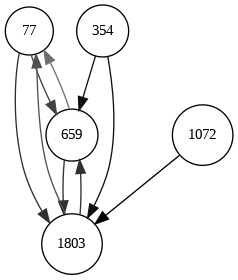

In [20]:
filename = "graph.gv"
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
explanation = explainer(data.x, data.edge_index, index=[77])
explanation.visualize_graph(backend="graphviz", path="default_graph.png")
display(Image(filename='default_graph.png'))

## Improved explanation plots

Two helper functions wich plot the improved drawings. The first visualizes the the node colors based on the ground truth classes and the second uses the predicted classes.
In both visualizations the currently explained node has a dashed border.

In [21]:
filename = "graph.gv"

def visualize_truth_explanation(explainer, indices, label):
  explanation = explainer(data.x, data.edge_index, index=indices) # running the explainer for the passed indices
  explanation.visualize_graph(backend="graphviz") # default visualization

  # enhanced visualization
  graphs = pydot.graph_from_dot_file(filename)
  graph = graphs[0]
  graph.set_label(label)
  graph.set_labelloc("t")
  graph.set_labeljust("l")
  graph.get_node("node")[0].set_colorscheme("set27")
  for n in graph.get_node_list():
    if n.get_name() != "node":
      if int(n.get_name()) in indices:
        graph.get_node(n.get_name())[0].set_fillcolor(data["y"][int(n.get_name())].item()+1)
        graph.get_node(n.get_name())[0].set_style("filled, dashed")
      else:
        graph.get_node(n.get_name())[0].set_style("filled")
        graph.get_node(n.get_name())[0].set_color(data["y"][int(n.get_name())].item()+1)
  truth_graph = graphviz.Source(graph.to_string())

  display_png(truth_graph)
  return explanation

def visualize_prediction_explanation(explainer, indices, label):
  pred = explainer.get_prediction(data.x, data.edge_index) # retrieving the node predictions
  pred_classes = torch.stack(list(map(lambda x: x.argmax() , pred)))

  explanation = explainer(data.x, data.edge_index, index=indices) # running the explainer for the passed indices
  explanation.visualize_graph(backend="graphviz") # default visualization

  # enhanced visualization
  graphs = pydot.graph_from_dot_file(filename)
  graph = graphs[0]
  graph.set_label(label)
  graph.set_labelloc("t")
  graph.set_labeljust("l")
  graph.get_node("node")[0].set_colorscheme("set27")
  for n in graph.get_node_list():
    if n.get_name() != "node":
      if int(n.get_name()) in indices:
        graph.get_node(n.get_name())[0].set_fillcolor(pred_classes[int(n.get_name())].item()+1)
        graph.get_node(n.get_name())[0].set_style("filled, dashed")
      else:
        graph.get_node(n.get_name())[0].set_style("filled")
        graph.get_node(n.get_name())[0].set_color(pred_classes[int(n.get_name())].item()+1)
  pred_graph = graphviz.Source(graph.to_string())

  display_png(pred_graph)
  return explanation

In [22]:
index = [77]

In [24]:
explanation = explainer(data.x, data.edge_index, index=index)

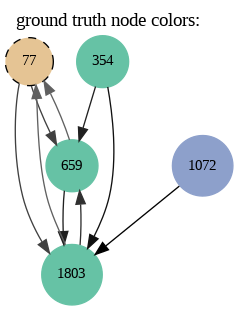

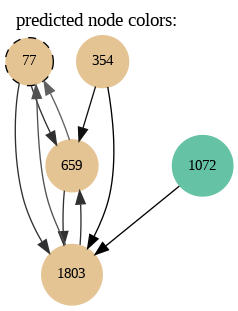

In [25]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

expl_t =visualize_truth_explanation(explainer, index, "ground truth node colors:")
expl_p =visualize_prediction_explanation(explainer, index, "predicted node colors:")

In [26]:
expl_t.edge_mask.unique()

tensor([0.0000, 0.9061, 0.9064, 0.9138, 0.9145, 0.9166, 0.9188, 0.9218, 0.9235,
        0.9273])

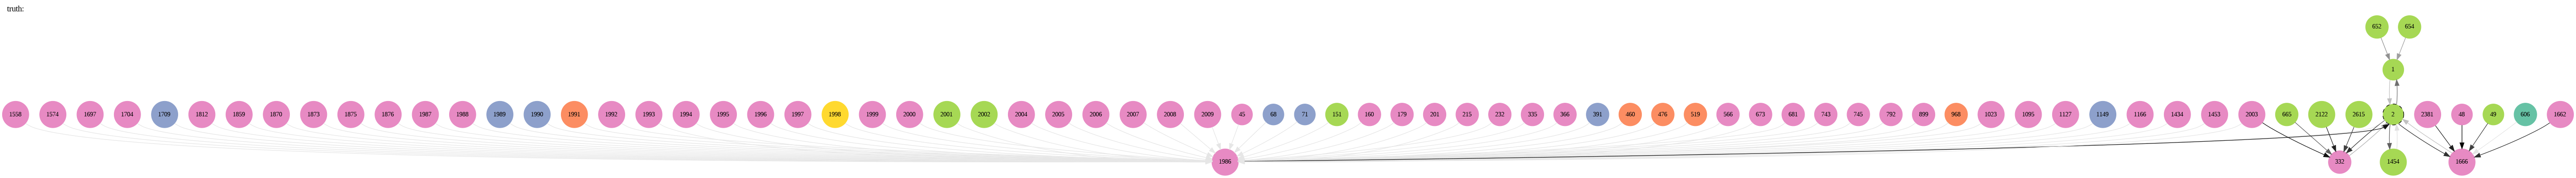

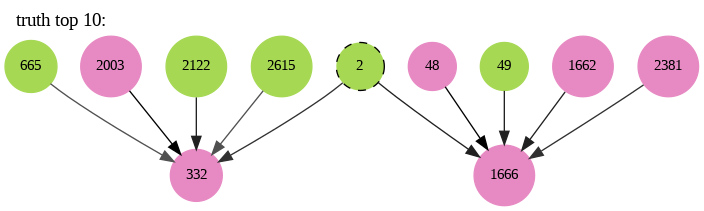

edge importance: tensor([0.0000, 0.0828, 0.0839, 0.0861, 0.0867, 0.0867, 0.0871, 0.0877, 0.0881,
        0.0882, 0.0887, 0.0889, 0.0891, 0.0892, 0.0894, 0.0897, 0.0897, 0.0900,
        0.0904, 0.0905, 0.0907, 0.0908, 0.0908, 0.0909, 0.0910, 0.0911, 0.0913,
        0.0913, 0.0914, 0.0914, 0.0914, 0.0914, 0.0915, 0.0915, 0.0916, 0.0916,
        0.0917, 0.0918, 0.0918, 0.0919, 0.0919, 0.0919, 0.0919, 0.0919, 0.0921,
        0.0923, 0.0923, 0.0924, 0.0924, 0.0924, 0.0925, 0.0925, 0.0925, 0.0925,
        0.0928, 0.0931, 0.0932, 0.0933, 0.0934, 0.0936, 0.0937, 0.0938, 0.0939,
        0.0948, 0.0950, 0.0957, 0.0962, 0.8570, 0.8731, 0.8800, 0.8814, 0.8842,
        0.8872, 0.8918, 0.8997, 0.9020, 0.9030, 0.9082, 0.9109, 0.9131, 0.9145,
        0.9146, 0.9151, 0.9163, 0.9201, 0.9239])


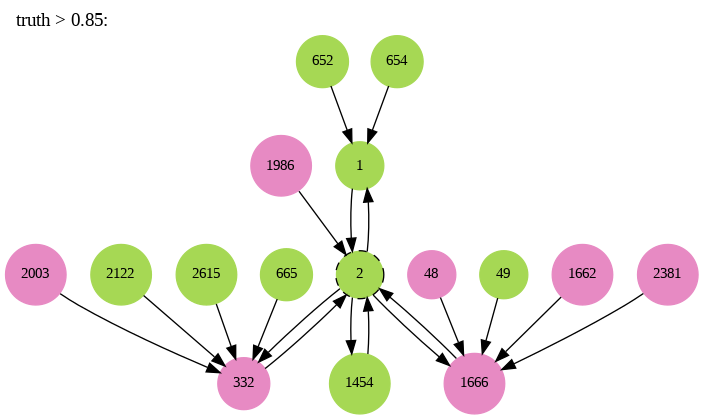

In [27]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
expl_t = visualize_truth_explanation(explainer, [2], "truth:")

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    threshold_config = dict(
        threshold_type = "topk",
        value = 10
    )
)
expl_t_10 = visualize_truth_explanation(explainer, [2], "truth top 10:")

print("edge importance:",expl_t.edge_mask.unique())

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    threshold_config = dict(
        threshold_type = "hard",
        value = 0.85
    )
)
expl_t_10 = visualize_truth_explanation(explainer, [2], "truth > 0.85:")

In [28]:
print(data.edge_index[0][0])
print(data.edge_index[1][0])
print(data.edge_index[1][1])
print(data.edge_index[1][2])

tensor(0)
tensor(633)
tensor(1862)
tensor(2582)


In [29]:
print((data.edge_index[0]==926).nonzero().squeeze())

tensor(3637)


In [30]:
data.edge_index[1][3637]

tensor(1862)

In [31]:
print((data.edge_index[1]==926).nonzero().squeeze())

tensor(7566)


In [32]:
data.edge_index[0][7566].item()

1862

# Legend

In [33]:
# based on https://keras.io/examples/graph/gnn_citations/
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

# based on https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/visualization/graph.py

def createNodeLegend():
  graph = pydot.Dot("legend_graph", graph_type="graph")
  graph.set_label('Node colors defined by node class:')
  graph.set_labelloc("t")
  graph.set_labeljust("l")
  for i in range(7):
    my_node = pydot.Node(i, label=label_dict[i], shape="circle")
    my_node.set_colorscheme("set27")
    my_node.set_color(i+1)
    my_node.set_style("filled")
    my_node.set_width(2)
    graph.add_node(my_node)

  my_node = pydot.Node(99, label="Currently explained", shape="circle")
  my_node.set_style("dashed")
  my_node.set_width(2)
  graph.add_node(my_node)

  legend_graph = graphviz.Source(graph.to_string())
  display_png(legend_graph)

In [34]:
# based on https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/visualization/graph.py
weights=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1 ]

def createEdgeColorLegend():
  graph = pydot.Dot("legend_graph", graph_type="graph")
  graph.set_label('Arrow colors defined by edge weight:')
  graph.set_labelloc("t")
  graph.set_labeljust("l")
  for w in weights:
    hex_color = hex(255 - round(255 * w))[2:]
    hex_color = f'{hex_color}0' if len(hex_color) == 1 else hex_color
    col = f'#{hex_color}{hex_color}{hex_color}'
    my_node = pydot.Node(str(w), label=str(w), shape="circle")
    my_node.set_color(col)
    my_node.set_style("filled")
    my_node.set_fontcolor("black")
    if(w >= 0.5):
      my_node.set_fontcolor("white")
    my_node.set_width(1)
    graph.add_node(my_node)

  legend_graph = graphviz.Source(graph.to_string())
  display_png(legend_graph)

In [35]:
def createArrowLegend():
  graph = pydot.Dot("legend_graph", graph_type='digraph')
  # graph.set_label('Arrow colors defined by edge weight:')
  graph.set_labelloc("t")
  graph.set_labeljust("l")

  for w in weights:
    hex_color = hex(255 - round(255 * w))[2:]
    hex_color = f'{hex_color}0' if len(hex_color) == 1 else hex_color
    col = f'#{hex_color}{hex_color}{hex_color}'

    graph.add_node(pydot.Node(str(w)+'a', shape='circle',color='white', width=0, label=""))
    graph.add_node(pydot.Node(str(w)+'b', shape='circle',color='white', width=0, label=""))
    my_edge = pydot.Edge(str(w)+'a', str(w)+'b',label=' '+str(w), color=col)
    graph.add_edge(my_edge)

  legend_graph = graphviz.Source(graph.to_string())
  display_png(legend_graph)

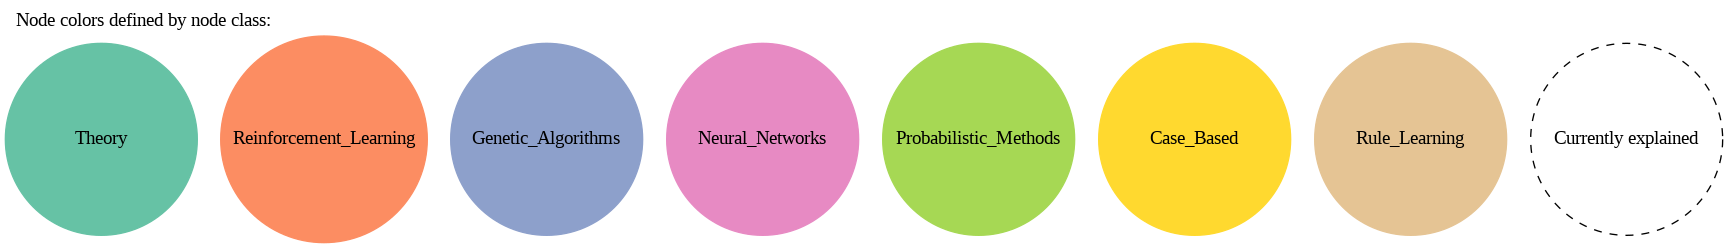

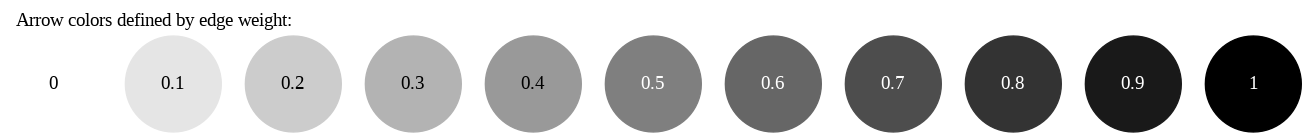

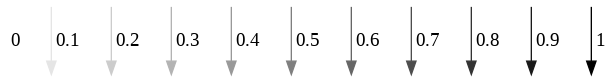

In [36]:
createNodeLegend()
createEdgeColorLegend()
createArrowLegend()